# Segment Anything Model の紹介

Meta 社の開発した画像セグメンテーション用のモデル

その名の通りどんなものでも Segmentation できるらしい

## TL; DR;

- Segment Anything Model は、画像のセグメンテーションを行うモデル
- 推論だけなら商用利用可能
- 学習無しで、どんなものでもセグメンテーション可能
- 精度もかなり高い


## 何に使うのか

- 中心にあるサークルの円周部分を特定するため
  - 円の内部は外的要因によって変化する可能性が高い
  - 安定した評価をするためには外周部分を特定する必要がある
  - そのためにはセグメンテーションが必要


## 動作サンプル

- 必須動作環境
  - Python >= 3.8
  - pythorch >= 1.7
    - CUDA >= 9.2
  - torchvision >= 0.8

[環境構築方法](https://github.com/facebookresearch/segment-anything?tab=readme-ov-file#installation)

### 事前準備

In [23]:
import numpy as np
import torch
import cv2

In [24]:
import math
import matplotlib.pyplot as plt

def show_anns(anns, ax = None):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = ax or plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

def show_mask(mask, ax, color=None):
    if color is None:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


In [25]:
# キャッシュの削除
torch.cuda.empty_cache()
torch.cuda.device_count()

1

### 入力画像

In [26]:
image = cv2.imread('../images/sample.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

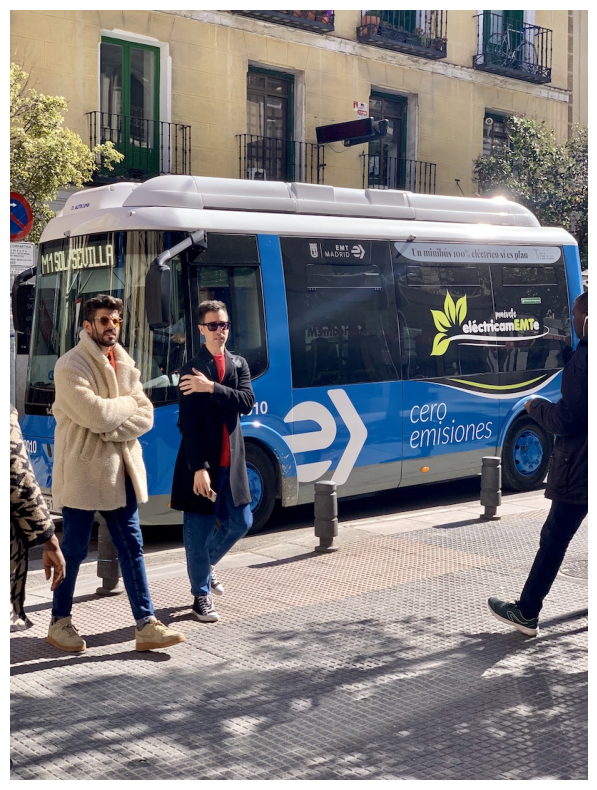

In [27]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.show()

### Segmentation の実行

Segment Anything モデルをロードして MaskGenerator を作成


In [28]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

sam_checkpoint = "../models/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

generate メソッドを実行
実行した結果は以下の通り

* `segmentation` : セグメンテーション領域のマスクデータ
* `area` : セグメンテーション領域の面積
* `bbox` : セグメンテーション領域のバウンディングボックス
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : オリジナル画像のセグメンテーションを実行した領域のバウンディングボックス

In [29]:
entire_masks = mask_generator.generate(image)

In [30]:
print(entire_masks[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


セグメンテーション結果をオリジナル画像に重ねて表示

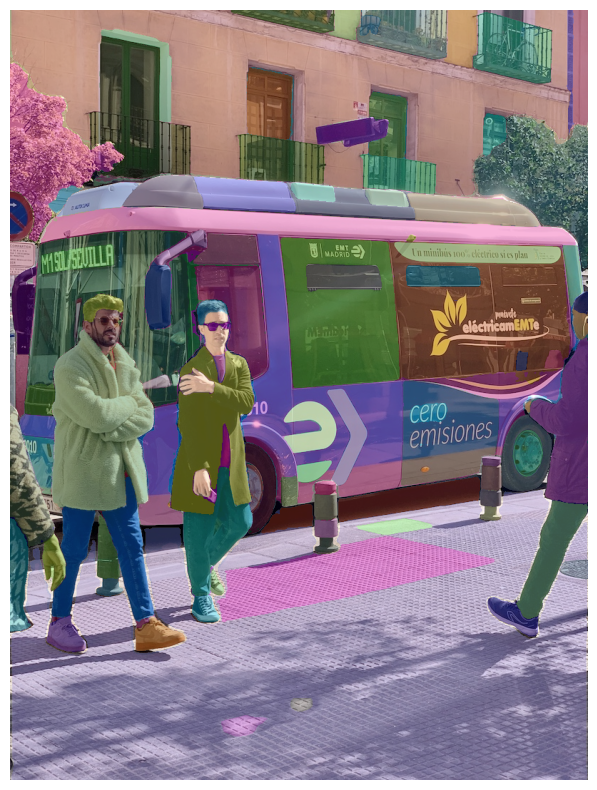

In [31]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(entire_masks)
plt.axis('off')
plt.show()

セグメンテーションした領域をすべて別々に表示

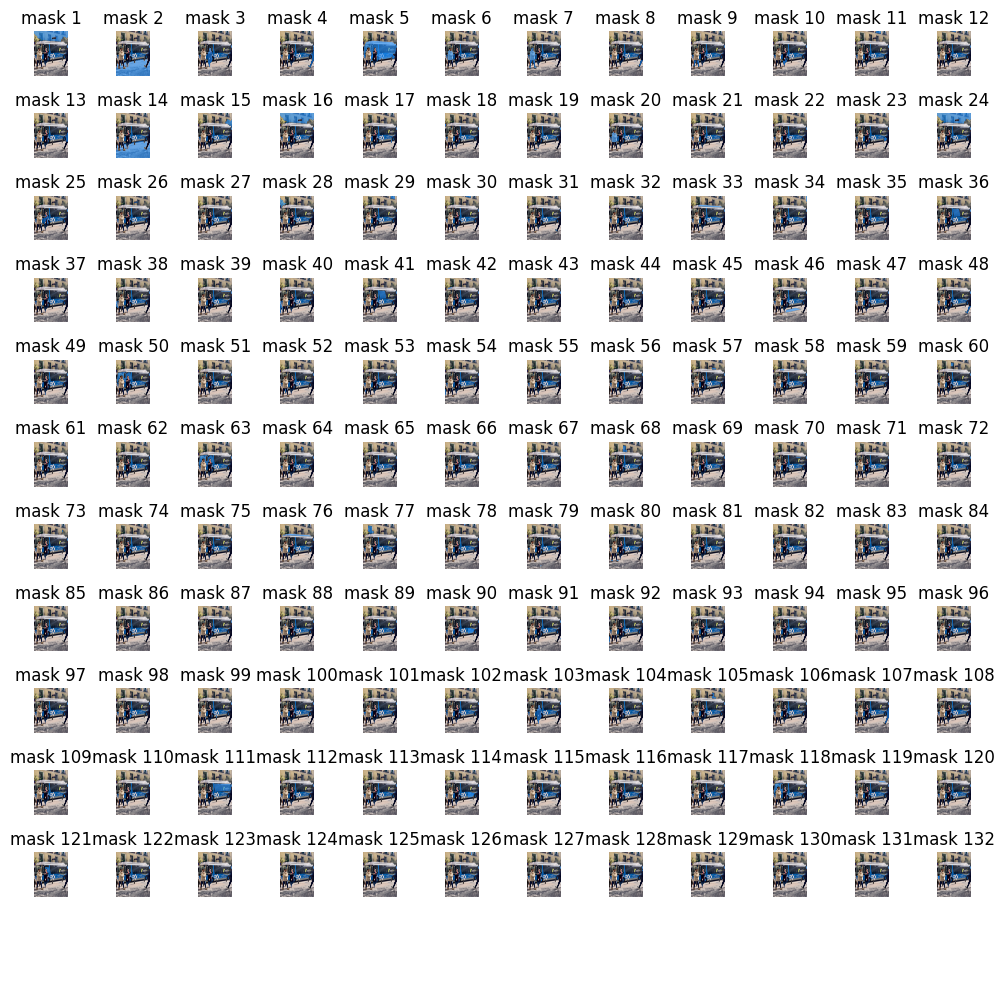

In [32]:
# グリッドのサイズを計算（画像の数の平方根を切り上げ）
grid_size = math.ceil(math.sqrt(len(entire_masks)))

fig, axs = plt.subplots(grid_size, grid_size, figsize=(10, 10))

for i, (mask, ax) in enumerate(zip(entire_masks, axs.flatten())):
    ax.imshow(image)
    show_mask(mask["segmentation"], ax, np.array([30/255, 144/255, 255/255, 0.6]))
    ax.axis('off')
    ax.set_title("mask {}".format(i+1))

# 余ったサブプロットを非表示にする
for ax in axs.flatten()[len(entire_masks):]:
    ax.axis('off')


plt.tight_layout()
plt.show()

In [33]:
import pandas as pd

df = pd.DataFrame(entire_masks)
df.head(10)

segmentation    area  \
0  [[False, False, True, True, True, True, True, ...  165588   
1  [[False, False, False, False, False, False, Fa...  255251   
2  [[False, False, False, False, False, False, Fa...   32728   
3  [[False, False, False, False, False, False, Fa...   20794   
4  [[False, False, False, False, False, False, Fa...  256906   
5  [[False, False, False, False, False, False, Fa...   27741   
6  [[False, False, False, False, False, False, Fa...   46442   
7  [[False, False, False, False, False, False, Fa...    6681   
8  [[False, False, False, False, False, False, Fa...   11025   
9  [[False, False, False, False, False, False, Fa...    8357   

                   bbox  predicted_iou            point_coords  \
0      [2, 0, 806, 259]       1.019298   [[113.90625, 50.625]]   
1    [0, 657, 808, 422]       1.017472  [[696.09375, 691.875]]   
2  [225, 407, 117, 451]       1.016195  [[240.46875, 658.125]]   
3  [670, 396, 139, 482]       1.014033  [[797.34375, 691.875]]   
4   [17, 231, 783, 493]       1.011851  [[493.59375, 320.625]]   
5   [59, 448, 141, 253]       1.010511  [[164.53125, 523.125]]   
6   [52, 398, 191, 502]       1.009262  [[189.84375, 590.625]]   
7  [709, 688, 100, 165]       1.008637  [[746.71875, 725.625]]   
8   [58, 654, 143, 203]       1.007554   [[88.59375, 793.125]]   
9   [243, 641, 96, 181]       1.007297  [[291.09375, 725.625]]   

   stability_score           crop_box  
0         0.986272  [0, 0, 810, 1080]  
1         0.964411  [0, 0, 810, 1080]  
2         0.980919  [0, 0, 810, 1080]  
3         0.973750  [0, 0, 810, 1080]  
4         0.953063  [0, 0, 810, 1080]  
5         0.984689  [0, 0, 810, 1080]  
6         0.975540  [0, 0, 810, 1080]  
7         0.986595  [0, 0, 810, 1080]  
8         0.978041  [0, 0, 810, 1080]  
9         0.974601  [0, 0, 810, 1080]

### 特定の領域のみで実行

セグメンテーションする領域を選ぶことも可能
領域の指定方法は2つ

- ポイント指定: そのポイント上にある Segment を特定する
- バウンディングボックス指定: そのバウンディングボックス内にある Segment を特定する

今回はポイント指定で実行

特定領域で使う場合には Predictor を使う

In [34]:
from segment_anything import SamPredictor

predictor = SamPredictor(sam)

画像の中心を指定して Segmentation を実行

Predictor の場合は dictionary ではなくタプルで結果が帰ってくるので注意

In [35]:
(w, h, _) = image.shape

point = np.array([[w/2, h/2]])
label = np.array([1])
predictor.set_image(image)

pointed_masks, scores, logits = predictor.predict(
    point_coords=point,
    point_labels=label,
    multimask_output=True,
)

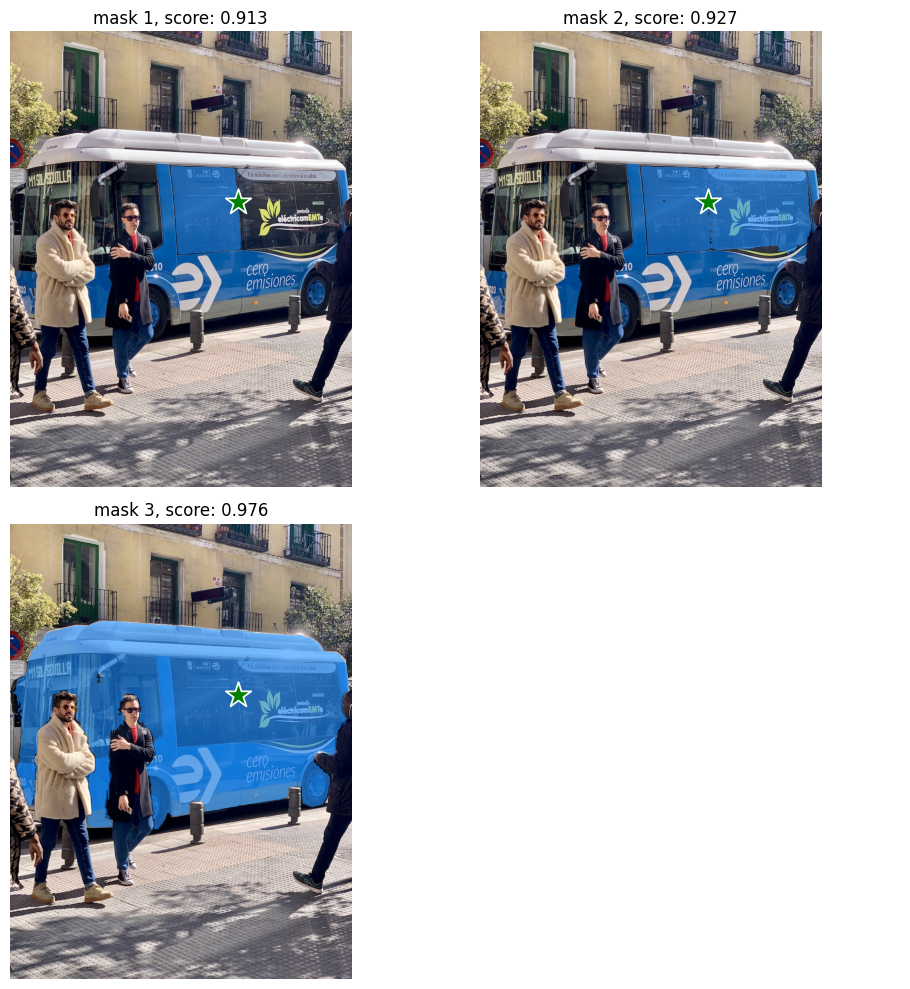

In [36]:
# グリッドのサイズを計算（画像の数の平方根を切り上げ）
grid_size = math.ceil(math.sqrt(len(pointed_masks)))

fig, axs = plt.subplots(grid_size, grid_size, figsize=(10, 10))

for i, (mask, ax) in enumerate(zip(pointed_masks, axs.flatten())):
    ax.imshow(image)
    show_mask(mask, ax, np.array([30/255, 144/255, 255/255, 0.6]))
    show_points(point, label, ax)
    ax.axis('off')
    ax.set_title(f"mask {i+1}, score: {scores[i]:.3f}")

# 余ったサブプロットを非表示にする
for ax in axs.flatten()[len(pointed_masks):]:
    ax.axis('off')


plt.tight_layout()
plt.show()

### 複数種類の画像で検証

画像の種類を変えても同じような認識結果になることの確認

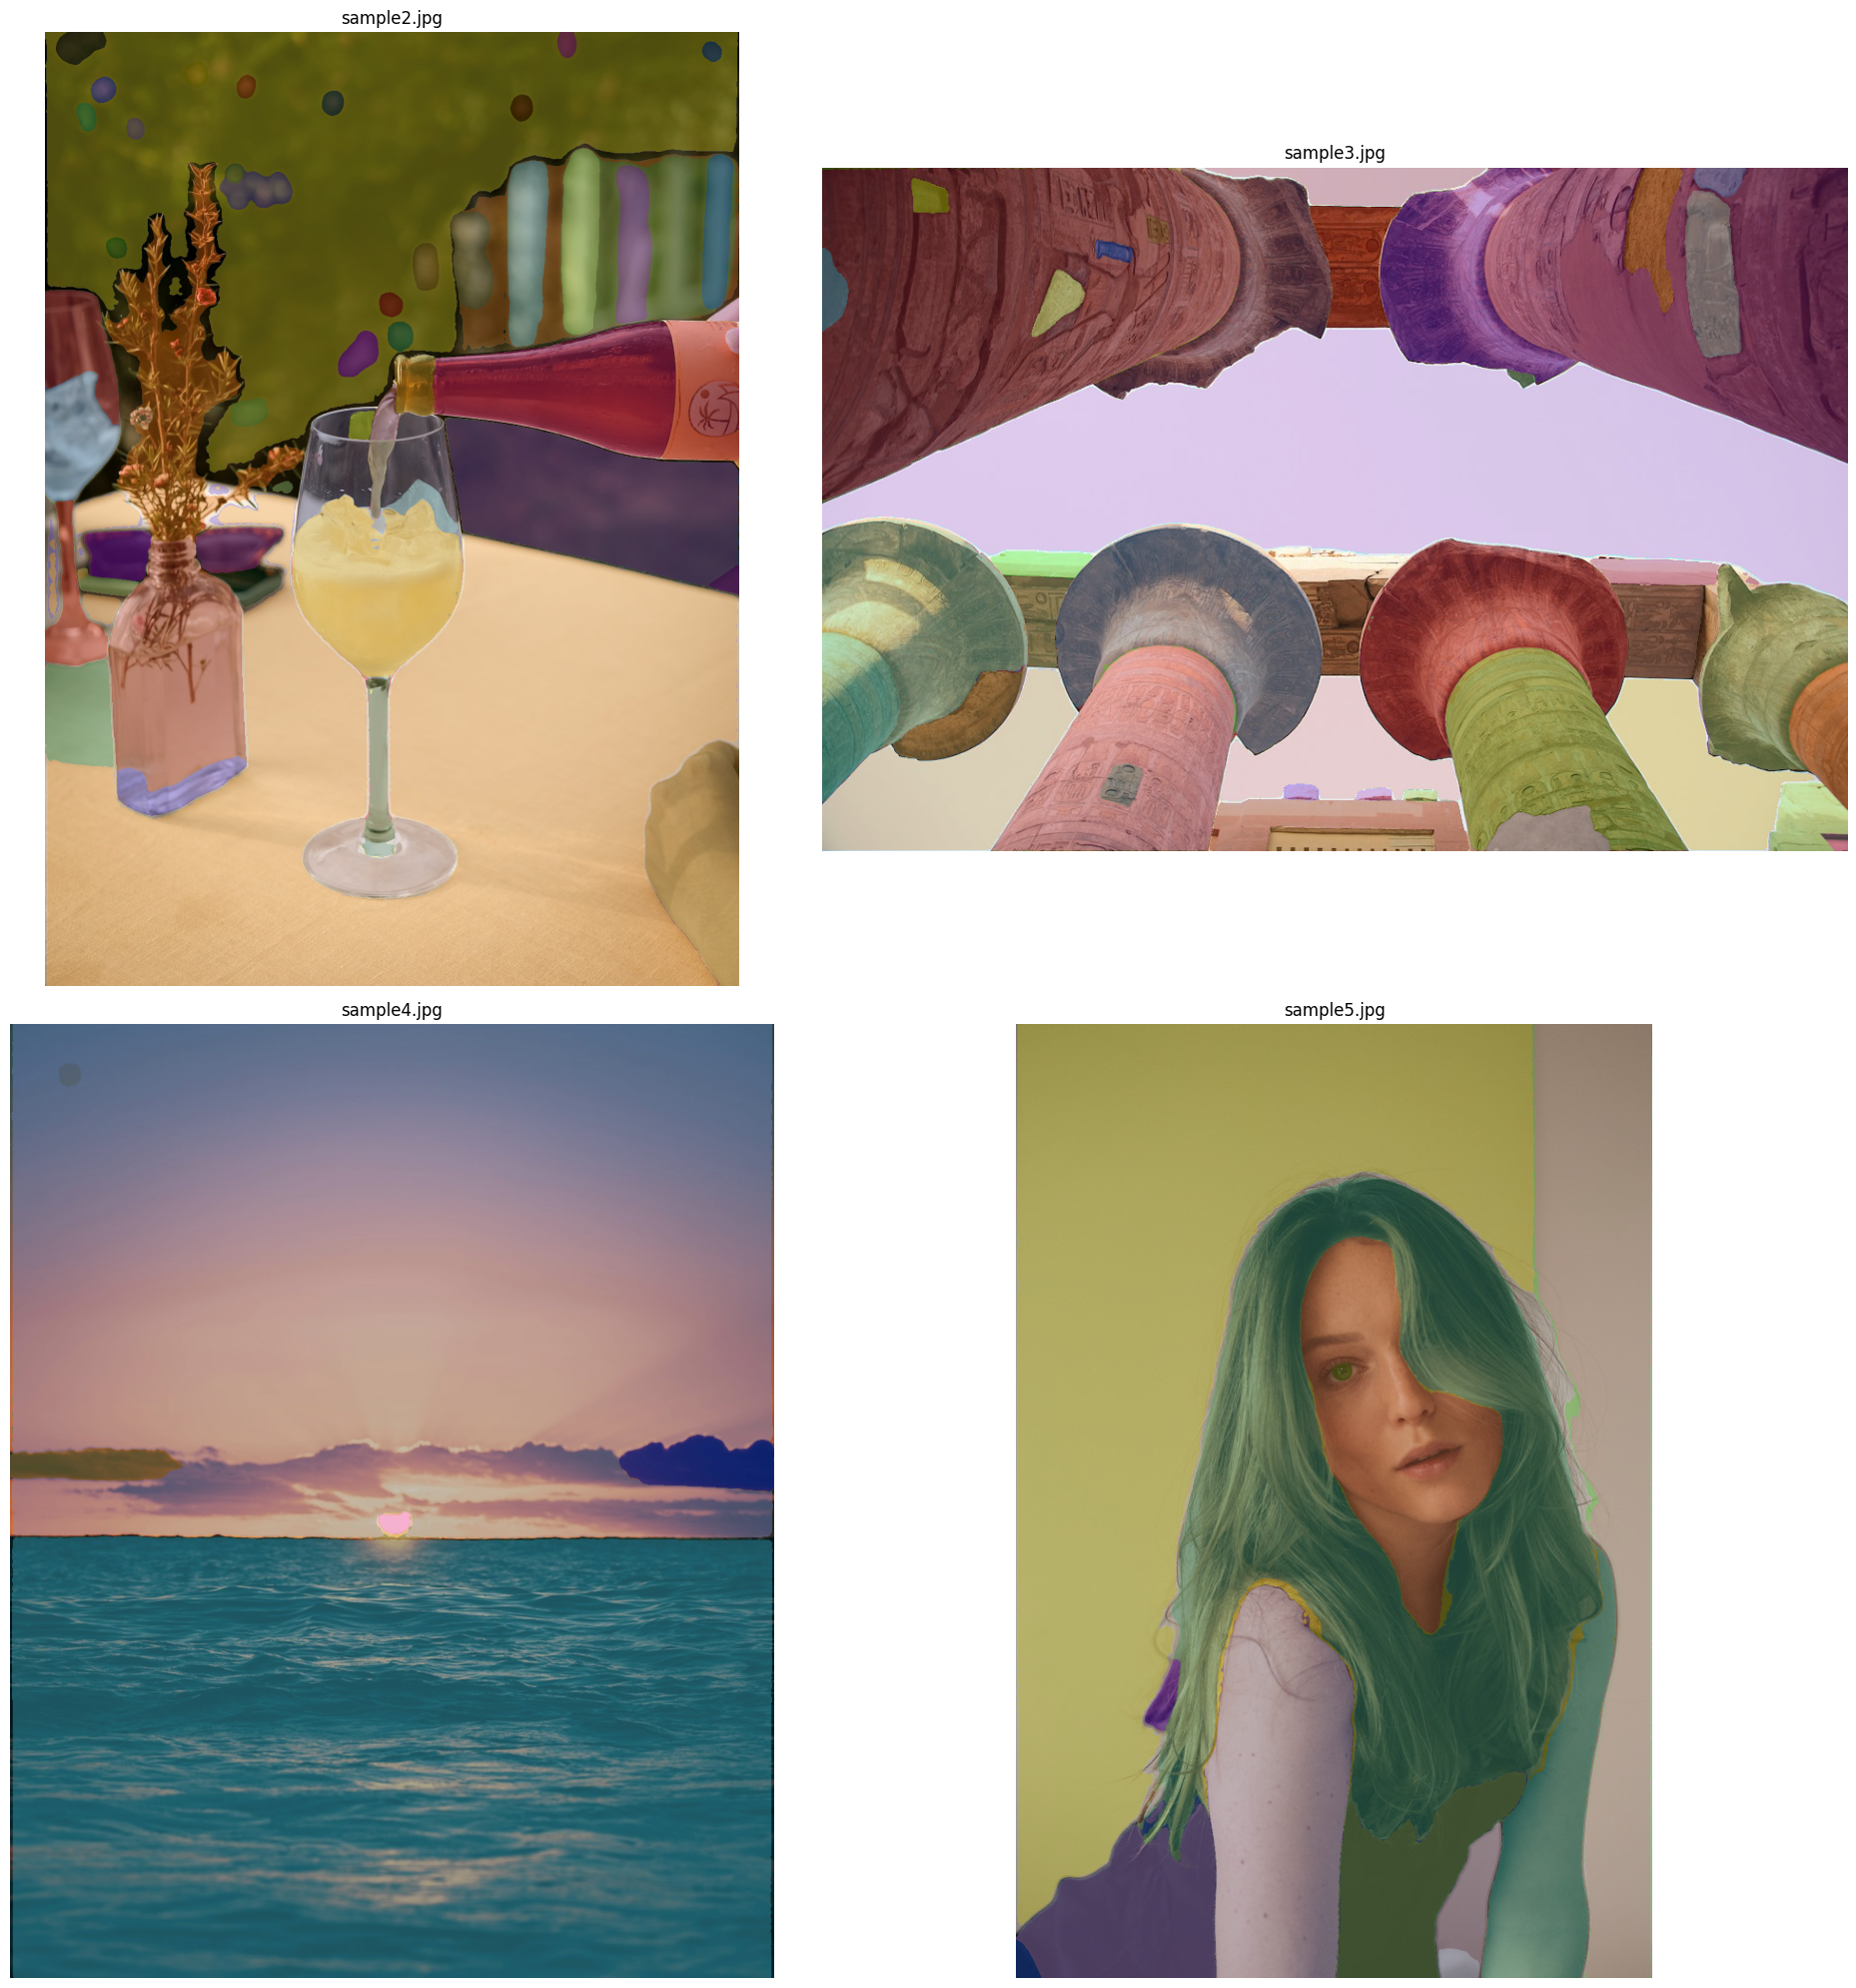

In [37]:
from pathlib import Path

# 画像のパスを取得
image_paths = list(Path("../images/samples").glob("*.jpg"))

# グリッドのサイズを計算（画像の数の平方根を切り上げ）
grid_size = math.ceil(math.sqrt(len(image_paths)))

fig, axs = plt.subplots(grid_size, grid_size, figsize=(20, 20))

for ax, image_path in zip(axs.flatten(), image_paths):
    _image = cv2.imread(str(image_path))
    _image = cv2.cvtColor(_image, cv2.COLOR_BGR2RGB)

    masks = mask_generator.generate(_image)

    ax.imshow(_image)
    show_anns(masks, ax)
    ax.axis('off')
    ax.set_title(image_path.name)

# 余ったサブプロットを非表示にする
for ax in axs.flatten()[len(image_paths):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

## エッジ部分の検出

1. 面積が最大のものを取得
   1. 中央の円部分が面積最大と判断
2. 面積が最大のもののエッジ部分を取得
   1. エッジの取得は OpenCV の `findContours` を使う

In [38]:
from functools import reduce

# 最大の面積を持つマスクを取得
areas = (list(
    map(lambda mask:
        reduce(lambda p, m: p + 1  if m else p, mask.flatten(), 0),
        pointed_masks
    )
))
max_area_mask = pointed_masks[np.argmax(areas)]

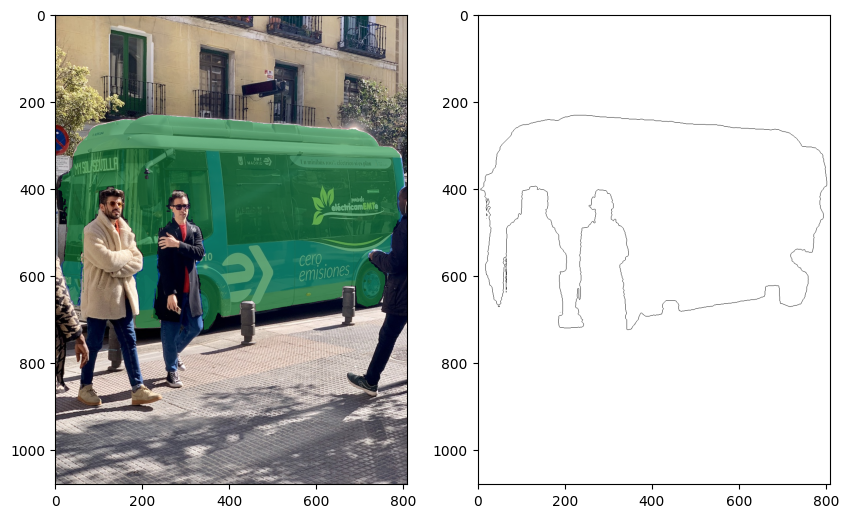

In [39]:
import cv2

# マスクデータをuint8型に変換
mask_uint8 = (max_area_mask * 255).astype(np.uint8)

# エッジの座標を検出
contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# エッジ部分だけをTrueにする新しいマスクを作成
edge_mask = np.zeros_like(max_area_mask, dtype=np.uint8)
cv2.drawContours(edge_mask, contours, -1, 1, 1)

fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(image)
show_mask(max_area_mask, axs[0])
show_mask(edge_mask, axs[1], np.array([0/255, 0/255, 0/255, 1]))
plt.show()

## 4K 画像読み込み時の GPU メモリ不足

自分の環境だと 4K の画像を読み込むと CUDA が GPU のメモリ不足を起こした。
エラーログを見るに、4K画像の推論には 12GB 以上のメモリが必要とのこと

`OutOfMemoryError: CUDA out of memory. Tried to allocate 12.00 GiB.`

In [40]:
image_4k = cv2.imread('../images/4k_sample.bmp')
image_4k = cv2.cvtColor(image_4k, cv2.COLOR_BGR2RGB)

masks_4k = mask_generator.generate(image_4k)

OutOfMemoryError: CUDA out of memory. Tried to allocate 12.00 GiB. GPU 0 has a total capacty of 16.00 GiB of which 10.41 GiB is free. Of the allocated memory 3.28 GiB is allocated by PyTorch, and 369.92 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF